# 4.3.4 多クラスロジスティック回帰
多クラス分類での事後確率 $\Pr(C_k | \Phi)$ を求めたい。

事後確率は特徴変数の線形関数のソフトマックス変換で以下のようにして与えられる。

$\displaystyle \Pr(C_k | \phi) = y_k(\phi) = \frac{\exp(a_k)}{\sum_{j} \exp(a_j)} \tag{4.104}$

ここで必要な activation $a_k$ は以下のようにして与えられる。

$a_k = w^T_k\phi \tag{4.105}$

そのため、重みパラメータ $\{w_k\}$ を求めたい。

** Section 4.2 ** の確率的生成モデルでは、事後確率を求めるためにクラスの条件付き確率密度とクラスの事前確率を別々に決めてベイズの定理を使ってパラメータ $\{w_k\}$を決定した。

今回は、ロジスティック回帰なので最尤法を用いて直接パラメータ $\{w_k\}$ を決定する。

$ \frac{\partial y_k}{\partial a_j} = y_k(I_{kj} - y_j) \tag{4.106}$

### 演習4.17

ソフトマックス活性関数 (4.104) の微分が (4.106) によって与えられることを示せ。  
ここで $a_k$ は (4.105) によって定義される。

$ \frac{\partial y_k}{\partial a_j} =
\left \{
\begin{array}{l}
\frac{\exp(a_k) (\sum \exp(a_j))
- \exp(a_k)\exp(a_k)}
{(\sum \exp(a_j))^2}
= y_k - y_k^2
& (j=k)\\
\frac{0 \bullet \exp(a_k) (\sum \exp(a_j)) - \exp(a_k)\exp(a_j)}
{(\sum \exp(a_j))^2}
= - \frac{\exp(a_k)\exp(a_j)}
{(\sum \exp(a_j))^2}
= -y_ky_j
& (j \ne k)
\end{array}
\right.$

2つをまとめると、

$ \frac{\partial y_k}{\partial a_j} = y_k(I_{kj} - y_j)$

次に尤度関数。1-of-K 符号化で表す。

$\displaystyle
\Pr(\mathbf{T} | \mathbf{w_1}, \ldots,\mathbf{w_k})
= \prod_{n=1}^{N}\prod_{k=1}^{K}\Pr(C_k|\phi_n)^{t_{nk}}
= \prod_{n=1}^{N}\prod_{k=1}^{K}y_{nk}^{t_{nk}}
 \tag{4.107}$

ここで、$y_{nk} = y_k(φ_n)$ であり、$\mathbf{T}$ は $t_{nk}$ を要素とする$N \times K$行列 ($N$は目的変数ベクトルの数、$K$はクラス数)


交差エントロピー誤差関数

$\displaystyle
E(\mathbf{w_1}, \ldots, \mathbf{w_k})
= -\ln \Pr(\mathbf{T}|\mathbf{w_1}, \ldots, \mathbf{w_k})
= -\sum_{n=1}^{N}\sum_{k=1}^{K}t_{nk} \ln y_{nk}
\tag{4.108}$

パラメータベクトル $\mathbf{w_1}$ に関する交差エントロピー誤差関数の勾配は、ソフトマックス関数の微分に対する結果 (4.106) を使って

$\displaystyle
\nabla_{\mathbf{w_j}} E(\mathbf{w_1}, \ldots, \mathbf{w_k})
= \sum_{n=1}^{N}(y_{nj} - t_{nj})\phi_n
\tag{4.109}$

ここでも交差エントロピー誤差関数の勾配は、誤差 $y_n - t_n$ と基底関数$\phi_n$ との積によって得られる。

### 演習4.18

$\displaystyle
  \frac{\partial E(\mathbf{w_1}, \ldots, \mathbf{w_k})}{\partial w_j}
= \frac{\partial E}{\partial y}
  \frac{\partial y_n}{\partial an}
  \nabla_{w_j} a_n
$

$\displaystyle
= \frac{\partial t_{nk} \log y_{nk}}{\partial y_{nk}}
  \frac{\partial y_{nk}}{\partial a_{nj}}
  \phi_n
$

$\displaystyle
= - \sum_{n, k}
    \frac{t_{nk}}{y_{nk}}
    y_{nk}(I_{kj} - y_{nj})
    \phi_n
$

$\displaystyle
 = - \sum_{n, k}t_{nk}
     \frac{y_k(\phi_n)(I_{kj}
   - y_j(\phi_n))}{y_k(\phi_n)}
     \phi_n
$

$\displaystyle = - \sum_{n, k} t_{nk} (I_{kj} - y_{nj}(\phi_n))\phi_n$

$\displaystyle = - \sum_{n}((\sum_{k}t_{nk}I_{kj}) - (\sum_{k}t_{nk}y_{nj}))\phi_n$

$\displaystyle = - \sum_{n}(t_{nj} - y_{nj})\phi_n$

$\displaystyle = \sum_{n}(y_{nj} - t_{nj})\phi_n$

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score


def _safe_exp(data):
    return np.exp(np.maximum(1e-15, data))


def _safe_log(data):
    return np.log(np.maximum(1e-323, data))


class SGDLogisticRegression(object):

    def __init__(self, η=.1):
        self.η = η        # Initial learning rate
        self.dec_η = .003  # amount of decrement η

    def y(self, φ, w):
        '''softmax'''
        y = _safe_exp(np.dot(φ, w))
        return y / y.sum()

    def En(self, φ, t, w):
        '''cross-entropy error function'''
        return -np.dot(_safe_log(self.y(φ, w)), t)
    
    def dEn(self, φ, t, w):
        '''gradient of cross-entropy error function'''
        return np.outer(φ, (self.y(φ, w) - t))

    def predict(self, Φ, w):
        return np.array([np.argmax(self.y(φ, w)) for φ in Φ])

    def plot(self, Φ, T, w):
        h = .01  # step size in the mesh

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        (x_min, x_max) = Φ[:, 0].min() - .05, Φ[:, 0].max() + .05
        (y_min, y_max) = Φ[:, 1].min() - .05, Φ[:, 1].max() + .05
        (xx, yy) = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = self.predict(np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])], w)

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.figure(1, figsize=(5, 4))
        plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel1)

        # Plot also the training points
        plt.scatter(Φ[:, 0], Φ[:, 1], c=T, edgecolors='k', cmap=plt.cm.prism)

        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())

        plt.show()

    def describe(self, i, Φ, T, w):
        print('iteration:', i)
        print('Negative Log Likelihood: %.3f' % sum((self.En(φ, t, w) for (φ, t) in zip(Φ, T))))
        print(w)
        Y = self.predict(Φ, w)
        print('Precision: %f' % precision_score(Y, T.nonzero()[1], average='micro'))
        print('Recall: %f' % recall_score(Y, T.nonzero()[1], average='micro'))
        self.plot(Φ, T, w)

    def train(self, Φ, T):
        Φ = np.c_[Φ, np.ones(Φ.shape[0])]  # Add bias column

        K = T.shape[1]   # number of classes
        M = Φ.shape[1]  # number of features
        N = Φ.shape[0]  # number of data


        print('K=%d, M=%d, N=%d' % (K, M, N))
        w = np.random.rand(M, K)
        i = 0
        self.describe(i, Φ, T, w)

        η = self.η
        ΦT = list(zip(Φ, T))
        prev_error = 999
        diff = 999
        while diff > 0.001:
            for (φ, t) in np.random.permutation(ΦT):
                w -= η * self.dEn(φ, t, w)
            i += 1
            # 途中経過
            if i % 5 == 0 or i == 1:
                self.describe(i, Φ, T, w)
            error = sum((self.En(φ, t, w) for (φ, t) in ΦT))
            diff = prev_error - error
            prev_error = error
            η -= self.dec_η
        # 最終結果
        if i % 5 > 0:
            self.describe(i, Φ, T, w)

K=3, M=3, N=300
iteration: 0
Negative Log Likelihood: 322.576
[[ 0.16786514  0.38788317  0.88921946]
 [ 0.7270767   0.96708187  0.54951818]
 [ 0.95573773  0.94344014  0.25569924]]
Precision: 0.333333
Recall: 0.333333


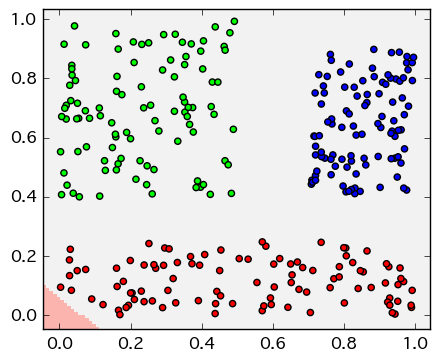

iteration: 1
Negative Log Likelihood: 155.603
[[ 0.55909263 -1.52517232  2.41104746]
 [-1.60953504  2.2932845   1.5599273 ]
 [ 1.64153532  0.91821863 -0.40487684]]
Precision: 0.930000
Recall: 0.930000


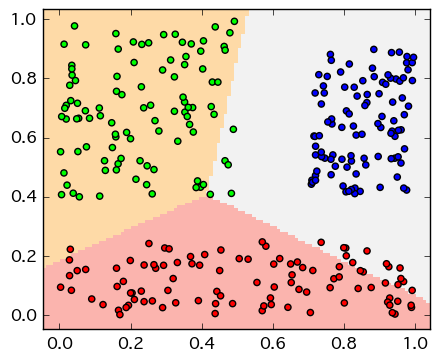

iteration: 5
Negative Log Likelihood: 63.538
[[ 0.87198534 -3.83320761  4.40619004]
 [-5.08487597  4.48163197  2.84692075]
 [ 3.1654795   1.15476745 -2.16536983]]
Precision: 0.993333
Recall: 0.993333


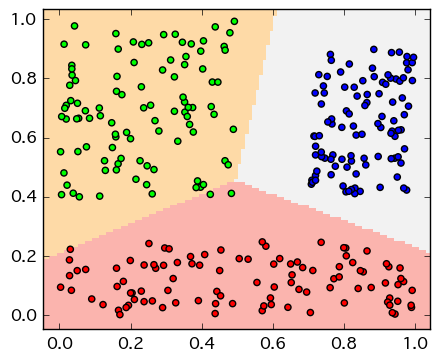

iteration: 10
Negative Log Likelihood: 43.112
[[ 0.91117901 -4.87400427  5.40779302]
 [-6.99923879  5.71074017  3.53217538]
 [ 3.94460683  1.35602639 -3.1457561 ]]
Precision: 0.993333
Recall: 0.993333


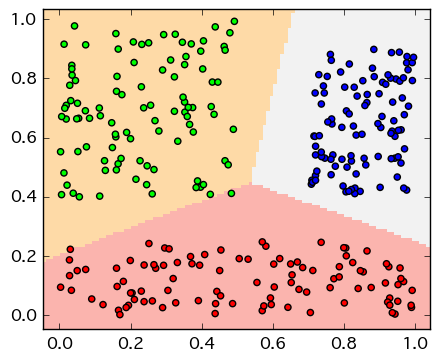

iteration: 15
Negative Log Likelihood: 34.798
[[ 0.89931784 -5.4870986   6.03274853]
 [-8.10075289  6.33705802  4.00737162]
 [ 4.41234118  1.35173973 -3.60920379]]
Precision: 0.996667
Recall: 0.996667


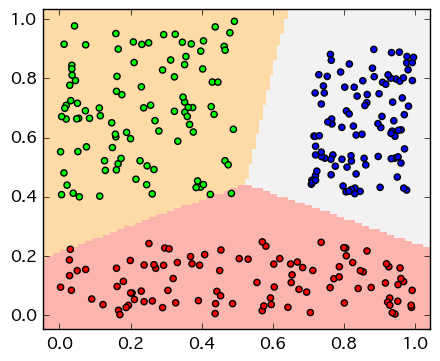

iteration: 20
Negative Log Likelihood: 30.714
[[ 0.89481884 -5.84512357  6.3952725 ]
 [-8.79087424  6.73658601  4.29796498]
 [ 4.71904726  1.36940069 -3.93357083]]
Precision: 0.996667
Recall: 0.996667


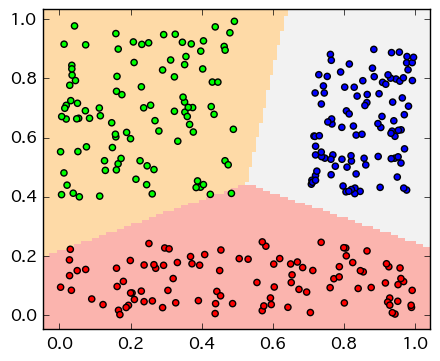

iteration: 25
Negative Log Likelihood: 28.475
[[ 0.87062339 -6.05657956  6.63092394]
 [-9.22647387  6.98713768  4.48301294]
 [ 4.87449188  1.39677211 -4.11638688]]
Precision: 0.996667
Recall: 0.996667


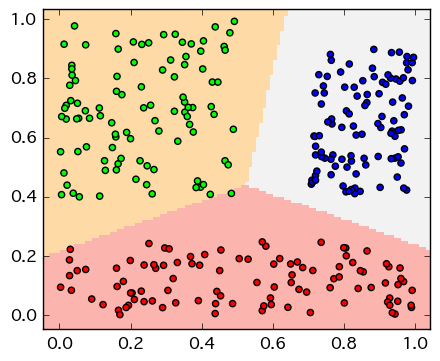

iteration: 30
Negative Log Likelihood: 27.393
[[ 0.86409502 -6.16638493  6.74725768]
 [-9.44999625  7.11624309  4.57742991]
 [ 4.96797489  1.40679464 -4.21989242]]
Precision: 0.996667
Recall: 0.996667


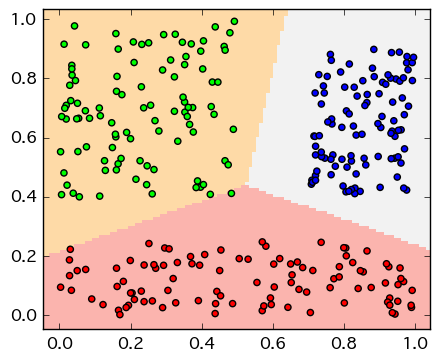

iteration: 35
Negative Log Likelihood: 27.177
[[ 0.86408313 -6.1881356   6.76902024]
 [-9.49513044  7.14325942  4.59554777]
 [ 4.98894873  1.40965699 -4.24372861]]
Precision: 0.996667
Recall: 0.996667


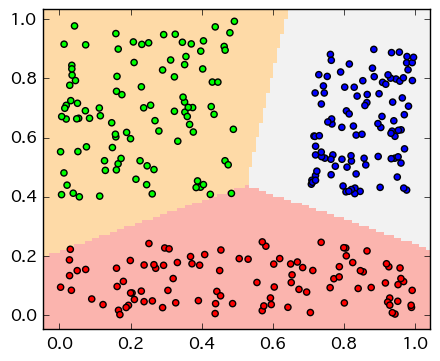

In [8]:
from sklearn import preprocessing

"""きれいに分離できそうなデータ"""
class1_x = np.random.uniform(0, 1, 100)
class1_y = np.random.uniform(0, 0.25, 100)

class2_x = np.random.uniform(0.0, 0.5, 100)
class2_y = np.random.uniform(0.4, 1, 100)

class3_x = np.random.uniform(0.7, 1, 100)
class3_y = np.random.uniform(0.4, 0.9, 100)

Φ = np.vstack([
        np.hstack([class1_x, class2_x, class3_x]),
        np.hstack([class1_y, class2_y, class3_y]),
    ]).T
lb = preprocessing.LabelBinarizer()
T = lb.fit_transform(np.array([0] * 100 + [1] * 100 + [2] * 100))

lr = SGDLogisticRegression()
lr.train(Φ, T)


K=3, M=3, N=150
iteration: 0
Negative Log Likelihood: 174.001
[[ 0.14380626  0.60554202  0.05486387]
 [ 0.74210708  0.44154465  0.95368286]
 [ 0.14822798  0.52832579  0.79049325]]
Precision: 0.066667
Recall: 0.066667


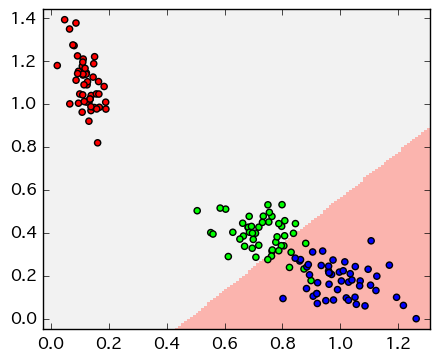

iteration: 1
Negative Log Likelihood: 96.120
[[-1.18597749  0.59534716  1.39484248]
 [ 2.21918264  0.24138626 -0.32323431]
 [ 0.16645645  0.51938452  0.78120604]]
Precision: 0.666667
Recall: 0.666667


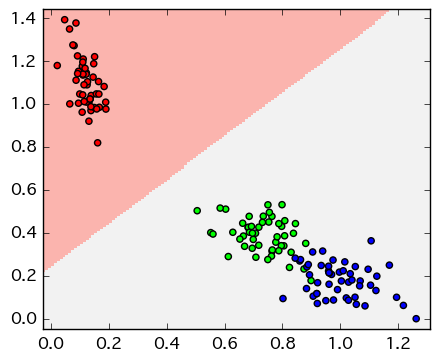

iteration: 5
Negative Log Likelihood: 56.698
[[-3.19765177  0.77605294  3.22581097]
 [ 4.18037454  0.37694423 -2.41998418]
 [-0.01571212  1.26480941  0.21794973]]
Precision: 0.953333
Recall: 0.953333


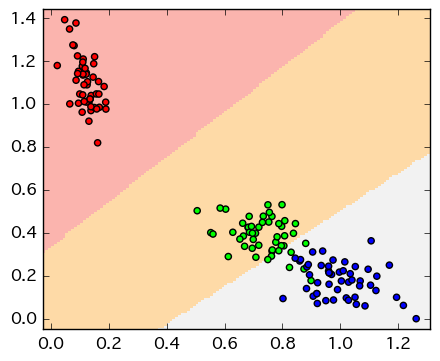

iteration: 10
Negative Log Likelihood: 43.697
[[-4.40467264  0.75586266  4.45302213]
 [ 5.33995432  0.57337528 -3.77599501]
 [-0.12919111  1.76951877 -0.17328065]]
Precision: 0.973333
Recall: 0.973333


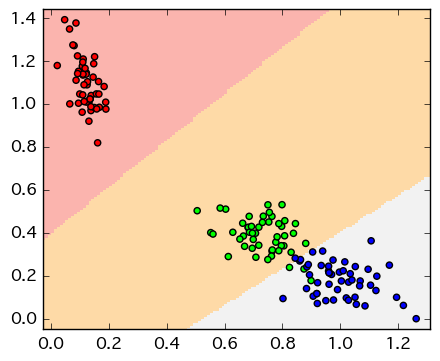

iteration: 15
Negative Log Likelihood: 38.010
[[-5.09768284  0.59990452  5.30199047]
 [ 6.06125457  0.63689845 -4.56081842]
 [-0.14300886  1.92447456 -0.31441869]]
Precision: 0.966667
Recall: 0.966667


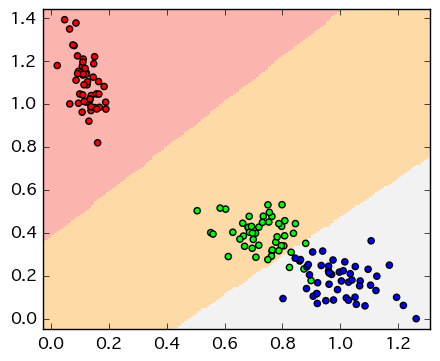

iteration: 20
Negative Log Likelihood: 34.452
[[-5.53823372  0.56459423  5.77785163]
 [ 6.50089806  0.71831307 -5.08187654]
 [-0.1661079   2.11995224 -0.48679732]]
Precision: 0.980000
Recall: 0.980000


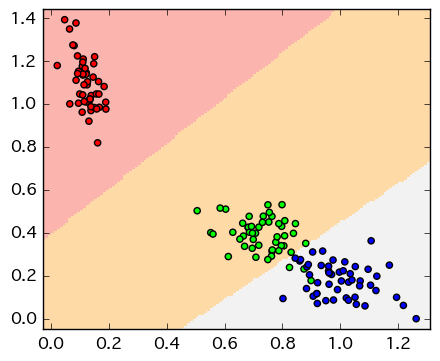

iteration: 25
Negative Log Likelihood: 32.452
[[-5.81042102  0.56215291  6.05248026]
 [ 6.76912175  0.78079269 -5.41257984]
 [-0.18254262  2.27289899 -0.62330935]]
Precision: 0.973333
Recall: 0.973333


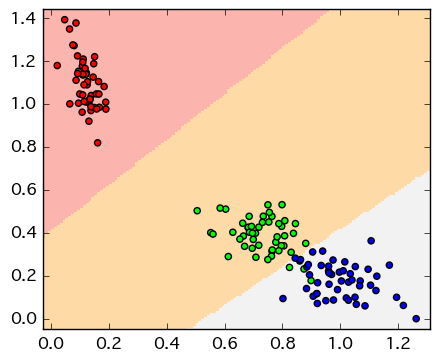

iteration: 30
Negative Log Likelihood: 31.566
[[-5.95198874  0.53852649  6.2176744 ]
 [ 6.91043379  0.80525169 -5.57835089]
 [-0.18931186  2.32695829 -0.67059942]]
Precision: 0.973333
Recall: 0.973333


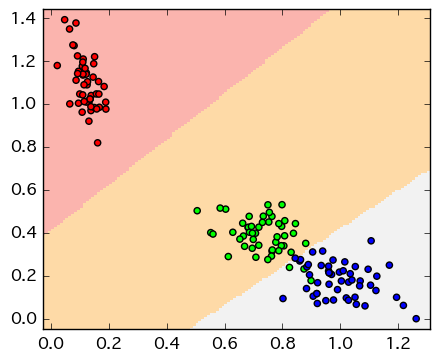

iteration: 35
Negative Log Likelihood: 31.388
[[-5.9809476   0.53658354  6.24857621]
 [ 6.9392562   0.81123145 -5.61315306]
 [-0.19075645  2.34145081 -0.68364734]]
Precision: 0.973333
Recall: 0.973333


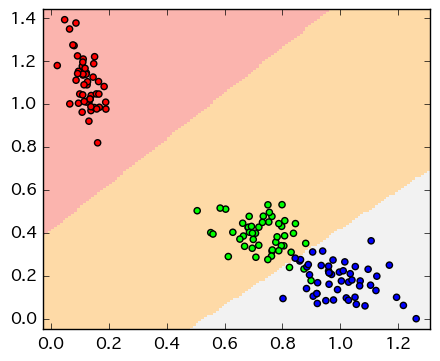

In [9]:
from sklearn import datasets
from sklearn import decomposition 


"""きれいに分離できなそうやつ (irisをむりやり2次元にした)"""
iris = datasets.load_iris()
Φ = iris.data
Φ = decomposition.NMF(2, solver='cd', shuffle=True).fit_transform(iris.data)

lb = preprocessing.LabelBinarizer()
T = lb.fit_transform(iris.target)


lr = SGDLogisticRegression()
lr.train(Φ, T)